# Лабораторная работа № 2 по курсу ML.
### Выполнил: Салихов Тимур, группа М8О-312Б-22

In [293]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

TRAIN_FILE_PATH = './nyc-taxi-trip-duration/train.csv'
VALIDATION_FILE_PATH = './nyc-taxi-trip-duration/test.csv'
SUBMISSION1_FILE_PATH = './submission1.csv'
SUBMISSION2_FILE_PATH = './submission2.csv'

## Подготовка данных

Загрузим наш датасет

In [294]:
train_df = pd.read_csv(TRAIN_FILE_PATH)
train_df

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2209155,2,2016-05-03 09:03:08,2016-05-03 09:17:12,2,-73.979813,40.752529,-73.982681,40.763680,N,844
1,id0586605,1,2016-01-01 16:40:51,2016-01-01 16:57:32,1,-73.977623,40.746296,-73.968414,40.788933,N,1001
2,id0467144,1,2016-04-24 13:57:03,2016-04-24 14:14:31,1,-73.950699,40.779404,-73.863129,40.768608,N,1048
3,id0989010,2,2016-01-10 17:03:47,2016-01-10 17:16:51,1,-73.984558,40.721802,-73.976753,40.752213,N,784
4,id0580742,1,2016-02-25 17:37:36,2016-02-25 17:49:48,1,-73.967720,40.768742,-73.977173,40.789875,N,732
...,...,...,...,...,...,...,...,...,...,...,...
1021045,id1753868,2,2016-03-25 07:11:49,2016-03-25 07:33:10,2,-73.955032,40.777328,-74.006203,40.749424,N,1281
1021046,id2204747,1,2016-02-16 18:01:45,2016-02-16 18:15:38,1,-73.973618,40.763920,-73.983849,40.749874,N,833
1021047,id3043606,2,2016-01-26 19:22:29,2016-01-26 19:43:54,1,-74.006195,40.734283,-73.949608,40.785282,N,1285
1021048,id1458584,1,2016-01-19 11:53:47,2016-01-19 12:00:16,1,-73.962341,40.767323,-73.969757,40.768669,N,389


Проанализируем столбцы таблицы и попробуем извлечь из нее признаки.

1. Столбец ```id``` для нас бесполезен, можем от него избавиться,
2. ```vendor_id``` напротив может нам быть полезен, оставим его как категориальный признак,
3. Из столбца ```pickup_datetime`` можем извлечь день, месяц, день недели, время в часах и время в минутах,
4. ```dropoff_datetime``` не будет присутствовать в подаваемых нам данных, поэтому его можно игнорировать,
5. ```passenger_count``` может также быть использован как категориальный признак,
6. Из данных ```pickup_latitude```, ```pickup_longitude```, ```dropoff_latitude```, ```dropoff_longitude``` можем найти расстояние между точками посадки и высадки. Данный подсчет можно проводить двумя методами:

    1. Манхеттенское расстояние,
    2. Метод великой окружности,

7. ```store_and_fwd_flag``` рассмотрим отдельно:

In [295]:
print(train_df['store_and_fwd_flag'].value_counts())

store_and_fwd_flag
N    1015403
Y       5647
Name: count, dtype: int64


Данная колонка на самом деле не является валидным параметром, так как ее результат логически не может влиять на время поездки, а также разница в количестве данных между классами слишком велика.

Для рассчета манхеттенского расстояния нам понадобится вспомогательная функция ```pd_manhattan_distance()```. Она принимает на вход ```DataFrame``` и добавляет к нему столбец ```distance```.

In [296]:
def pd_manhattan_distance(df: pd.DataFrame) -> pd.DataFrame:
    df['distance'] = np.abs(df['dropoff_latitude'] - df['pickup_latitude']) * 111.32 + \
                            np.abs(df['dropoff_longitude'] - df['pickup_longitude']) * 111.32 * \
                            np.cos(df['pickup_latitude'] * np.pi / 180)

    return df

Для расчета великой окружности нам понадобится вспомогательная функция ```pd_great_circle()```. Она принимает на вход ```DataFrame```, рассчитывает расстояние при помощи функции ```great_circle()``` из библиотеки ```geopy``` и добавляет столбец ```distance``` к датафрейму.

In [297]:
from geopy.distance import great_circle

def pd_great_circle(df: pd.DataFrame) -> pd.DataFrame:
    df['distance'] = df.apply(lambda row: great_circle(
        (row['pickup_latitude'], row['pickup_longitude']), 
        (row['dropoff_latitude'], row['dropoff_longitude'])
        ).km, axis=1)
    
    return df

Теперь мы можем составить функцию ```feature_generator()```, которая позволит нам генерировать фичи из исходных данных, а затем удалять ненужные столбцы. Среди параметров функции присутствует ```dist_calc```, который позволяет нам считать расстояние разными способами.

In [298]:
def feature_generator(df: pd.DataFrame, dist_calc: callable, sub=False) -> pd.DataFrame:
    output_df = df.copy()

    # Extracting time features
    output_df['pickup_datetime'] = pd.to_datetime(output_df['pickup_datetime'])
    output_df['day'] = output_df['pickup_datetime'].dt.day
    output_df['month'] = output_df['pickup_datetime'].dt.month
    output_df['day_week'] = output_df['pickup_datetime'].dt.day_of_week
    output_df['hours'] = output_df['pickup_datetime'].dt.hour
    output_df['minutes'] = output_df['pickup_datetime'].dt.minute

    # Calculating distance
    dist_calc(output_df)
    
    # Dropping unused columns
    unused = ['id', 'pickup_datetime', 'pickup_longitude', 
              'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
              'store_and_fwd_flag']
    
    output_df = output_df.drop(columns=unused)

    if not sub:
        output_df = output_df.drop(columns=['dropoff_datetime'])

    return output_df
    

Теперь применим функцию к исходным данным и посмотрим на результат

In [299]:
train_df1 = feature_generator(train_df, pd_manhattan_distance)
train_df1

,vendor_id,passenger_count,trip_duration,day,month,day_week,hours,minutes,distance
0,2,2,844,3,5,1,9,3,1.483168
1,1,1,1001,1,1,4,16,40,5.522967
2,1,1,1048,24,4,6,13,57,8.583480
3,2,1,784,10,1,6,17,3,4.043807
4,1,1,732,25,2,3,17,37,3.149524
...,...,...,...,...,...,...,...,...,...
1021045,2,2,1281,25,3,4,7,11,7.419861
1021046,1,1,833,16,2,1,18,1,2.426192
1021047,2,1,1285,26,1,1,19,22,10.450423
1021048,1,1,389,19,1,1,11,53,0.775127


In [300]:
train_df2 = feature_generator(train_df, pd_great_circle)
train_df2

,vendor_id,passenger_count,trip_duration,day,month,day_week,hours,minutes,distance
0,2,2,844,3,5,1,9,3,1.263189
1,1,1,1001,1,1,4,16,40,4.804019
2,1,1,1048,24,4,6,13,57,7.471099
3,2,1,784,10,1,6,17,3,3.444874
4,1,1,732,25,2,3,17,37,2.481066
...,...,...,...,...,...,...,...,...,...
1021045,2,2,1281,25,3,4,7,11,5.310391
1021046,1,1,833,16,2,1,18,1,1.783780
1021047,2,1,1285,26,1,1,19,22,7.407657
1021048,1,1,389,19,1,1,11,53,0.642216


Мы извлекли всю нужную информацию и избавились от ненужных столбцов. Однако теперь необходимо проанализировать наши данные на выбросы, чтобы исключить их из выборки, тем самым повысив ее качество.

Напишем вспомогательную функцию ```draw_boxenplot()```, которая позволит визуализировать выбросы в числовых признаках

In [301]:
def draw_boxenplot(data: pd.DataFrame, columns: list[str]) -> None:
    _, ax = plt.subplots(figsize=(10, 6 * len(columns)), nrows=len(columns))

    if len(columns) == 1:
        sns.boxenplot(data[columns[0]], ax=ax)
    else:
        for i in range(len(columns)):
            sns.boxenplot(data[columns[i]], ax=ax[i])
            
    plt.show()

Напишем функцию ```draw_histplot()```, которая позволит визуализировать распределение значений числовых признаков

In [302]:
def draw_histplot(data: pd.DataFrame, columns: list[str]) -> None:
    _, ax = plt.subplots(figsize=(10, 6 * len(columns)), nrows=len(columns))

    if len(columns) == 1:
        sns.histplot(data[columns[0]], ax=ax, kde=True)
    else:
        for i in range(len(columns)):
            sns.histplot(data[columns[i]], ax=ax[i], kde=True)
            
    plt.show()

Напишем функцию ```draw_pieplot()```, которая позволит визуализировать распределение в категориальных признаках.

In [303]:
def draw_pie(data: pd.DataFrame, columns: list[str]) -> None:
    _, ax = plt.subplots(figsize=(10, 6 * len(columns)), nrows=len(columns))

    palette = sns.color_palette('dark')

    if len(columns) == 1:
        ax.pie(data[columns[0]].value_counts().sort_index(), 
               colors=palette, labels=sorted(data[columns[0]].unique()))
        ax.set_title(columns[0])
    else:
        for i in range(len(columns)):
            ax[i].pie(data[columns[i]].value_counts().sort_index(), 
                      colors=palette, labels=sorted(data[columns[i]].unique()))
            ax[i].set_title(columns[i])
            
    plt.show()

Теперь определим функцию ```remove_outliers()```, которая поможет нам избавиться от выбросов

In [304]:
def remove_outliers(data: pd.DataFrame, columns: list[str]) -> pd.DataFrame:
    for col in columns:
        Q1 = data[col].quantile(0.05)
        Q2 = data[col].quantile(0.95)

        outliers = data[(data[col] < Q1) | (data[col] > Q2)]

        data = data.drop(outliers.index)
    
    return data
        

Теперь разделим наши признаки на числовые и категориальные:

In [305]:
categorical_features = ['vendor_id', 'passenger_count', 'month', 'day_week']

numeric_features = ['day', 'hours', 'minutes', 'distance']

target = ['trip_duration']

Проверим на наличие выбросов числовые признаки и таргет. Поскольку ```train_df1``` и ```train_df2``` различаются лишь в одном параметре и лишь незначительно, то рассмотрим только ```train_df1```

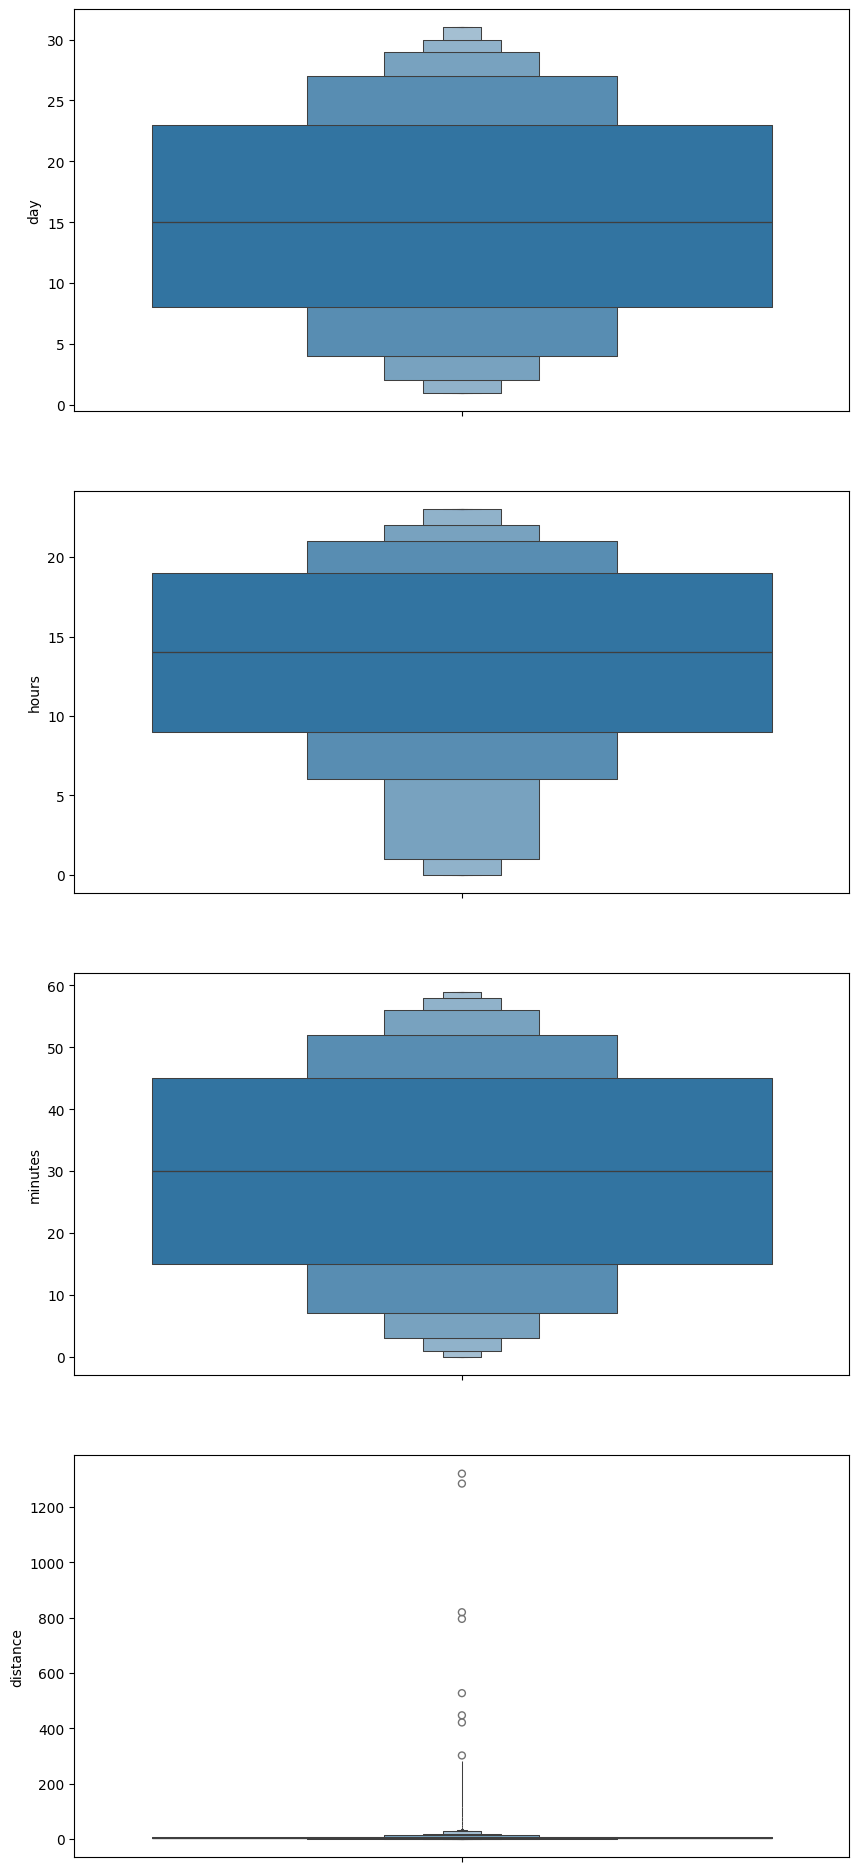

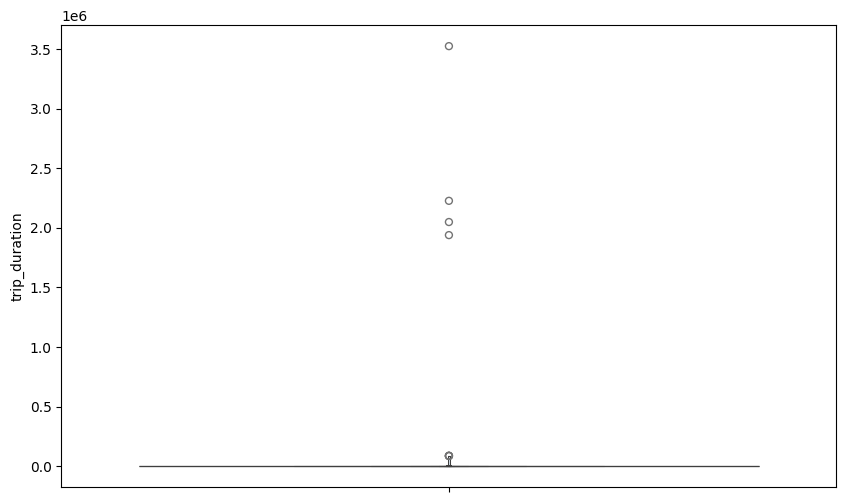

In [306]:
draw_boxenplot(train_df1, numeric_features)
draw_boxenplot(train_df1, target)

Как видим, есть выбросы в признаках ```duistance``` и ```trip_duration```. Избавимся от них при помощи заранее подготовленной функции.

In [307]:
train_df1 = remove_outliers(train_df1, ['trip_duration', 'distance'])
train_df1

,vendor_id,passenger_count,trip_duration,day,month,day_week,hours,minutes,distance
0,2,2,844,3,5,1,9,3,1.483168
1,1,1,1001,1,1,4,16,40,5.522967
2,1,1,1048,24,4,6,13,57,8.583480
3,2,1,784,10,1,6,17,3,4.043807
4,1,1,732,25,2,3,17,37,3.149524
...,...,...,...,...,...,...,...,...,...
1021043,1,1,1912,21,6,1,10,2,4.924034
1021044,1,1,468,30,5,0,22,10,2.101561
1021045,2,2,1281,25,3,4,7,11,7.419861
1021046,1,1,833,16,2,1,18,1,2.426192


In [308]:
train_df2 = remove_outliers(train_df2, ['trip_duration', 'distance'])
train_df2

,vendor_id,passenger_count,trip_duration,day,month,day_week,hours,minutes,distance
0,2,2,844,3,5,1,9,3,1.263189
1,1,1,1001,1,1,4,16,40,4.804019
2,1,1,1048,24,4,6,13,57,7.471099
3,2,1,784,10,1,6,17,3,3.444874
4,1,1,732,25,2,3,17,37,2.481066
...,...,...,...,...,...,...,...,...,...
1021043,1,1,1912,21,6,1,10,2,4.544479
1021044,1,1,468,30,5,0,22,10,2.040312
1021045,2,2,1281,25,3,4,7,11,5.310391
1021046,1,1,833,16,2,1,18,1,1.783780


Теперь снова проверим на выбросы

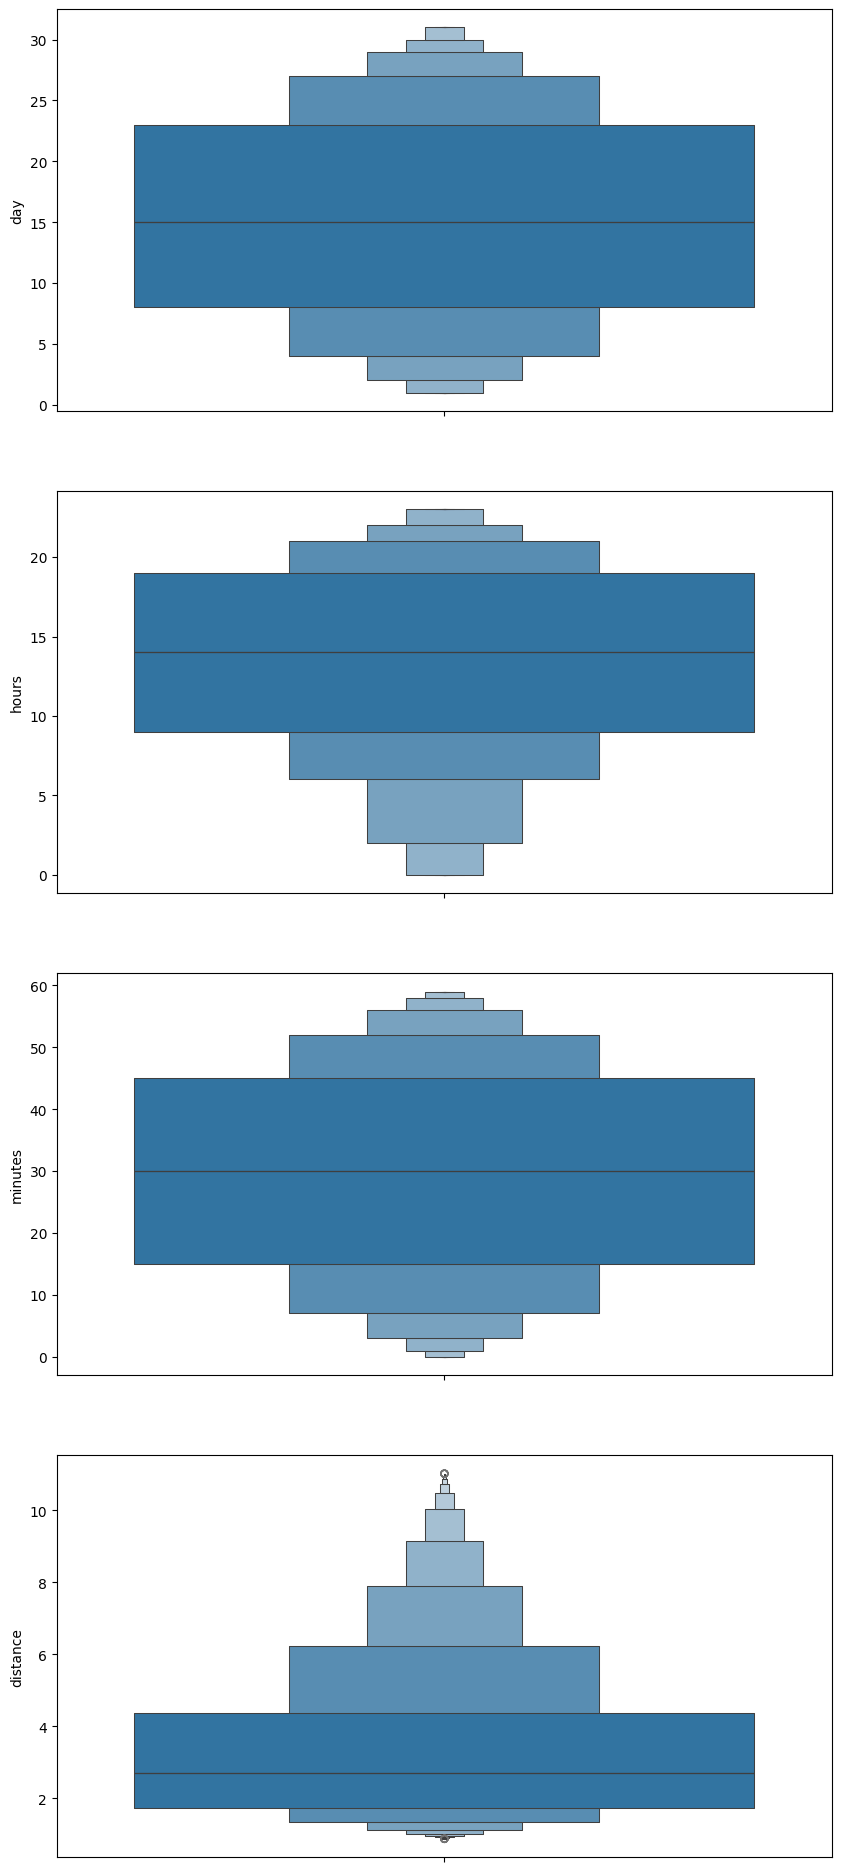

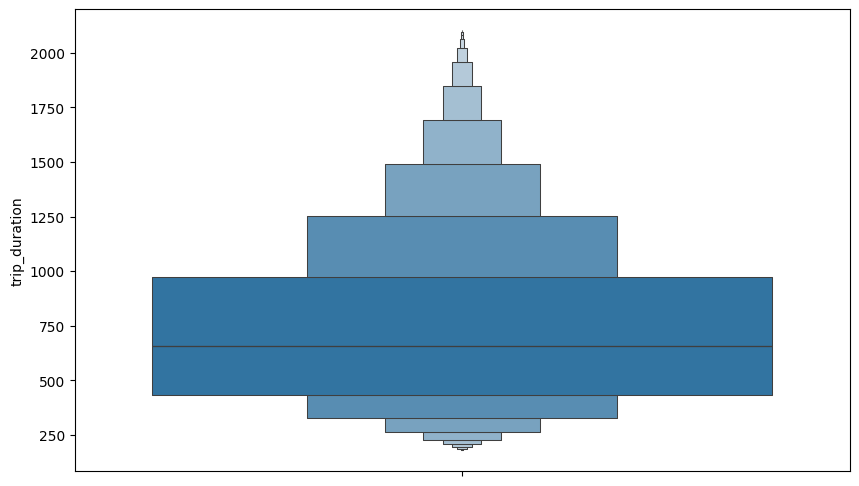

In [309]:
draw_boxenplot(train_df1, numeric_features)
draw_boxenplot(train_df1, ['trip_duration'])

Как видим, наши признаки и таргет теперь не имеют выбросов.

Теперь посомтрим на распределения наших параметров

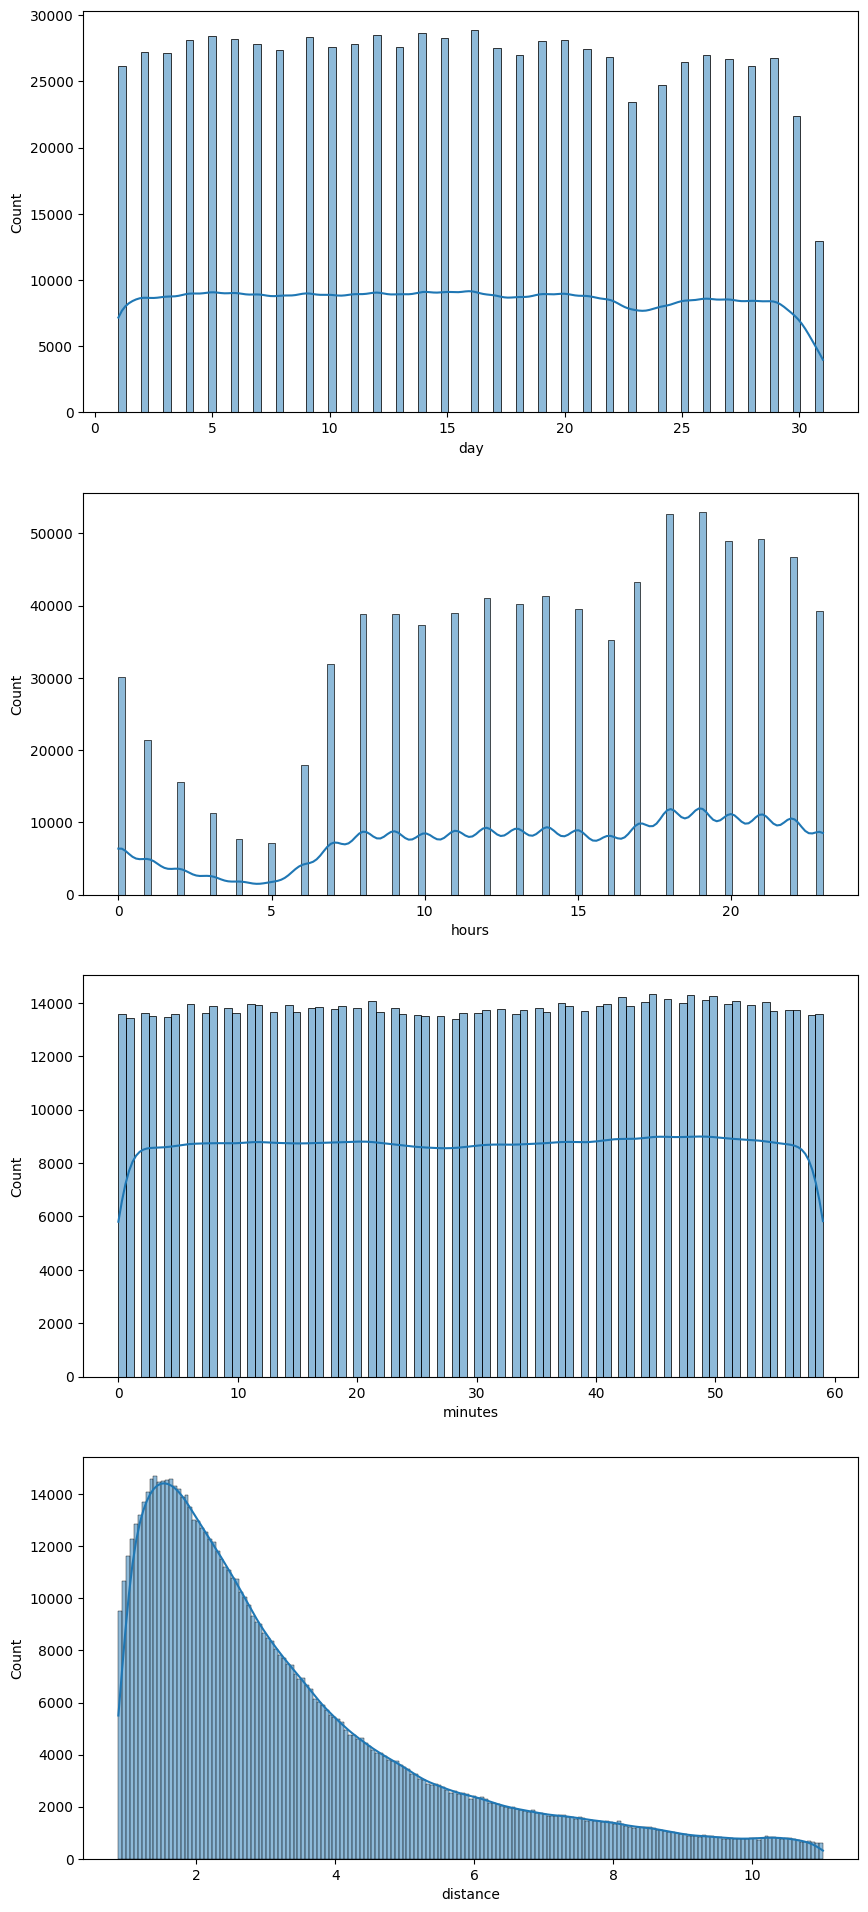

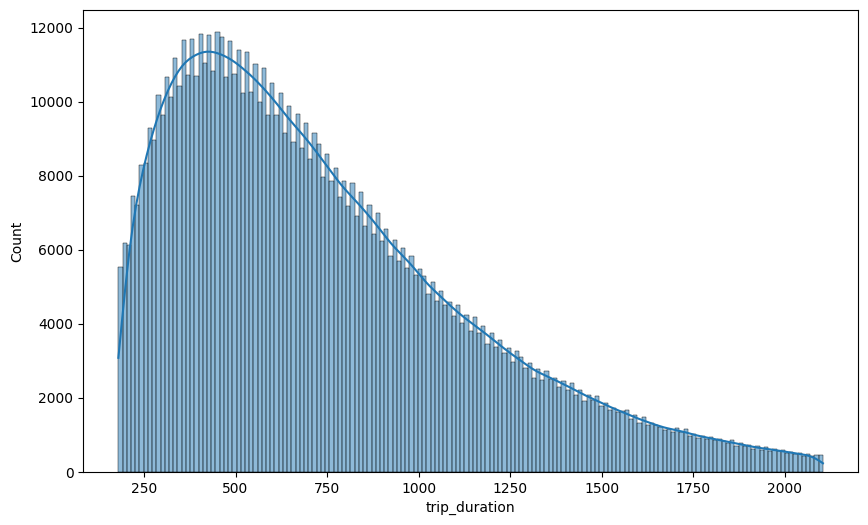

In [310]:
draw_histplot(train_df1, numeric_features)
draw_histplot(train_df1, target)

Как видим, распределение ```distance``` и ```trip_duration``` несколько смещено. Прологарифмируем их.

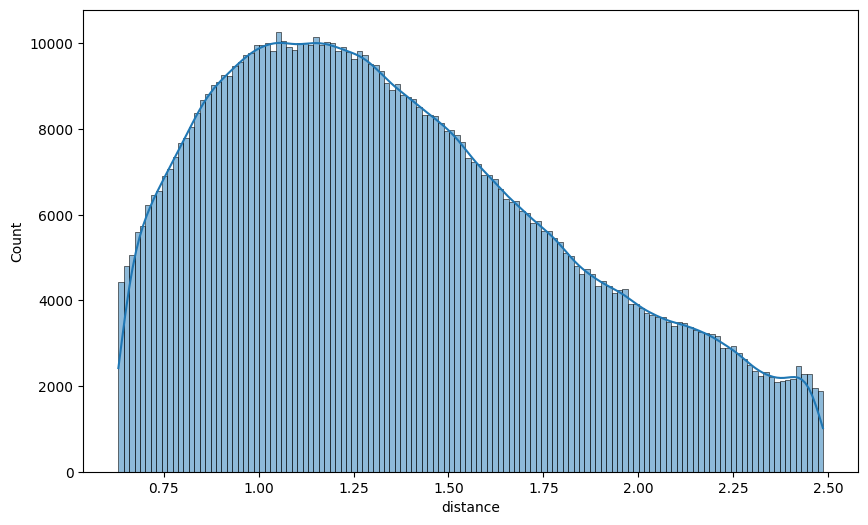

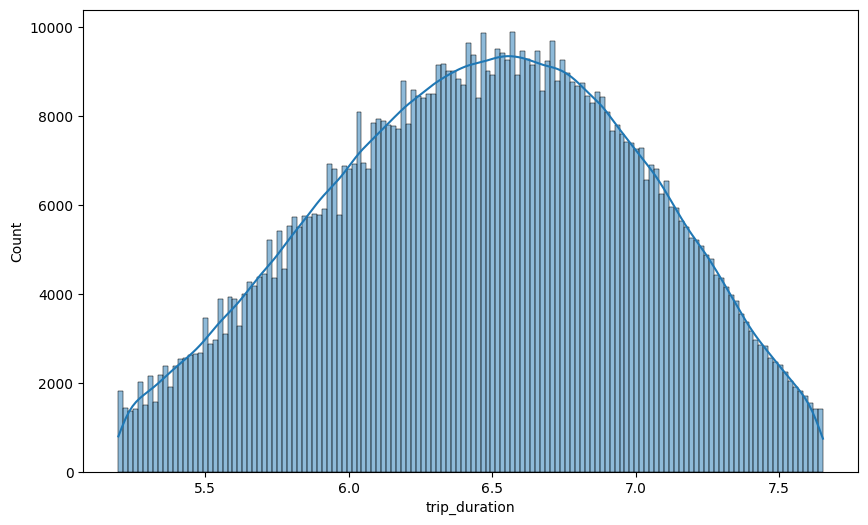

In [311]:
train_df1['distance'] = np.log1p(train_df1['distance'])
train_df2['distance'] = np.log1p(train_df2['distance'])

draw_histplot(train_df1, ['distance'])
draw_histplot(np.log1p(train_df1), target)

Как видим распределение стало больше похоже на нормальное

Постороим диаграммы для категориальных признаков

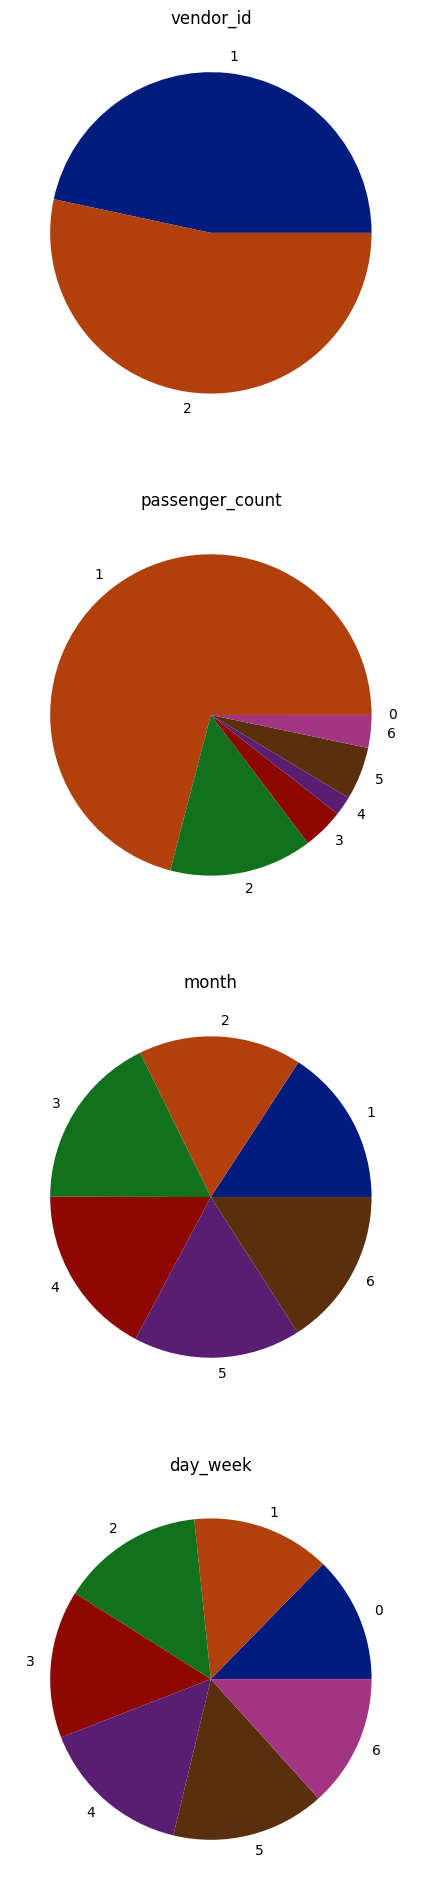

In [312]:
draw_pie(train_df1, categorical_features)

Также имеет смысл рассмотреть среднюю скорость. Во время попыток предсказаний она естественно будет неизвестна, поэтому использовать ее как параметр не получится, однако во входных данных также могут быть выбросы и по скорости.

In [313]:
train_df1['speed'] = train_df1['distance'] / train_df1['trip_duration']
train_df2['speed'] = train_df2['distance'] / train_df2['trip_duration']

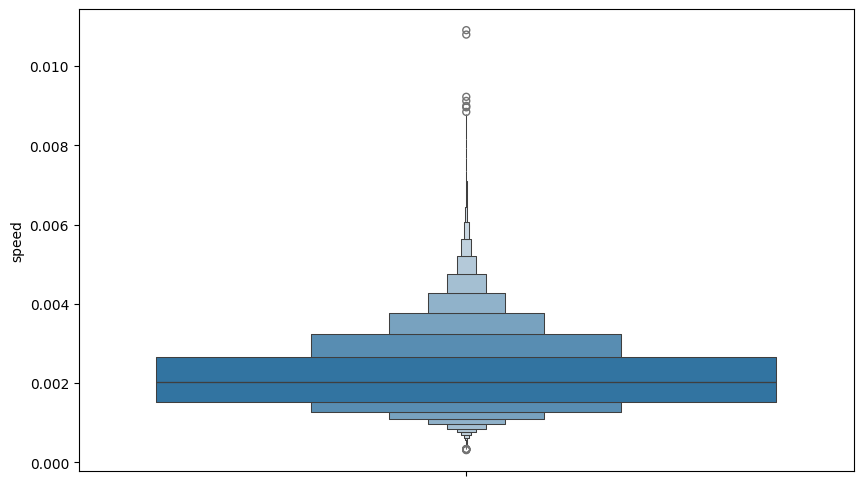

In [314]:
draw_boxenplot(train_df1, ['speed'])

In [315]:
train_df1 = remove_outliers(train_df1, ['speed'])
train_df1

,vendor_id,passenger_count,trip_duration,day,month,day_week,hours,minutes,distance,speed
0,2,2,844,3,5,1,9,3,0.909535,0.001078
1,1,1,1001,1,1,4,16,40,1.875329,0.001873
2,1,1,1048,24,4,6,13,57,2.260041,0.002157
3,2,1,784,10,1,6,17,3,1.618161,0.002064
4,1,1,732,25,2,3,17,37,1.422994,0.001944
...,...,...,...,...,...,...,...,...,...,...
1021042,2,1,1180,26,3,5,8,10,2.245723,0.001903
1021044,1,1,468,30,5,0,22,10,1.131905,0.002419
1021045,2,2,1281,25,3,4,7,11,2.130593,0.001663
1021046,1,1,833,16,2,1,18,1,1.231449,0.001478


In [316]:
train_df2 = remove_outliers(train_df2, ['speed'])
train_df2

,vendor_id,passenger_count,trip_duration,day,month,day_week,hours,minutes,distance,speed
0,2,2,844,3,5,1,9,3,0.816775,0.000968
1,1,1,1001,1,1,4,16,40,1.758551,0.001757
2,1,1,1048,24,4,6,13,57,2.136660,0.002039
3,2,1,784,10,1,6,17,3,1.491751,0.001903
4,1,1,732,25,2,3,17,37,1.247339,0.001704
...,...,...,...,...,...,...,...,...,...,...
1021042,2,1,1180,26,3,5,8,10,1.979995,0.001678
1021044,1,1,468,30,5,0,22,10,1.111960,0.002376
1021045,2,2,1281,25,3,4,7,11,1.842198,0.001438
1021046,1,1,833,16,2,1,18,1,1.023810,0.001229


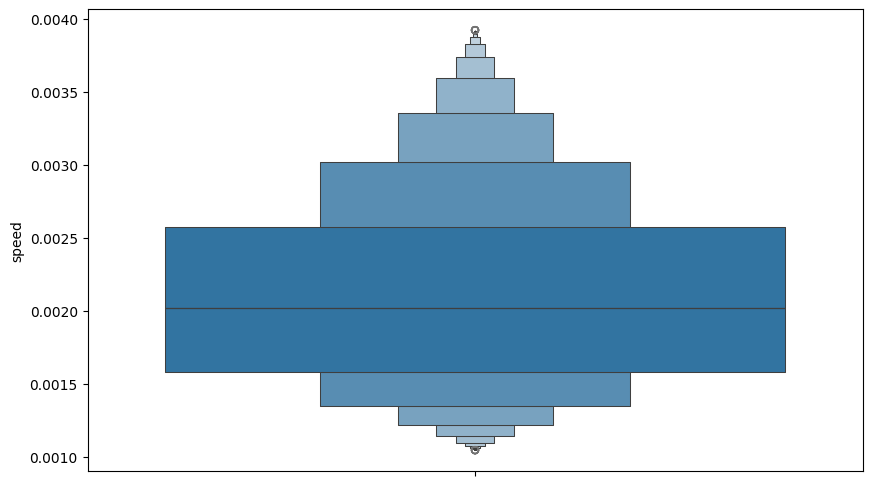

In [317]:
draw_boxenplot(train_df1, ['speed'])

Как видим, нам удалось хорошо избавиться от выбросов. Теперь можно убрать этот столбец.

In [318]:
train_df1 = train_df1.drop(columns='speed')
train_df2 = train_df2.drop(columns='speed')

Теперь посомтрим на корелляцию между параметрами

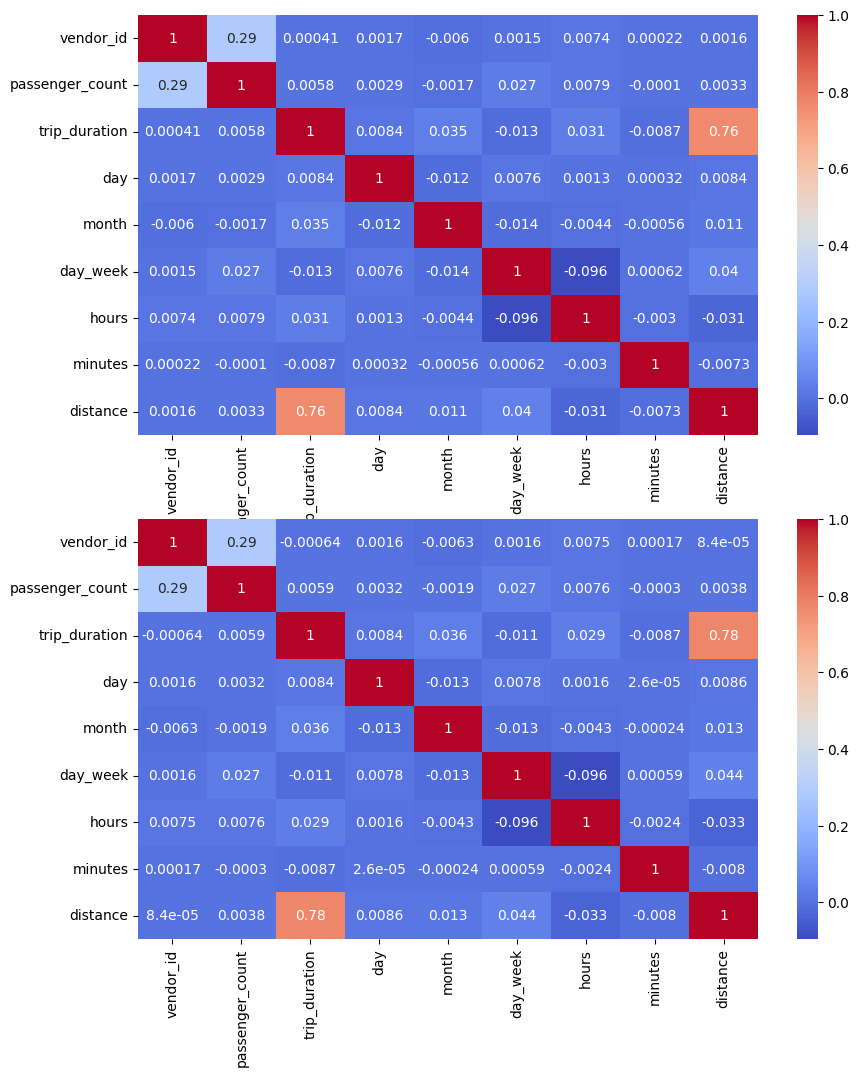

In [319]:
_, ax = plt.subplots(figsize=(10, 12), nrows=2)

sns.heatmap(train_df1.corr(), cmap='coolwarm', annot=True, ax=ax[0])
sns.heatmap(train_df2.corr(), cmap='coolwarm', annot=True, ax=ax[1])
plt.show()

Все признаки независимы друг от друга. Значение таргета как можно заметить зависят больше всего от расстояния.

## Обучение модели

Для числовых применим standard scaler, для категориальных one-hot encoder

In [335]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer

ohe_vendor = OneHotEncoder(categories=[[1, 2]])
ohe_passenger_count = OneHotEncoder(categories=[np.arange(0, 10).tolist()])
ohe_month = OneHotEncoder(categories=[np.arange(1, 13).tolist()])
ohe_day_week = OneHotEncoder(categories=[np.arange(0, 7).tolist()])

ct = ColumnTransformer([
    ('ohe1', ohe_vendor, ['vendor_id']),
    ('ohe2', ohe_passenger_count, ['passenger_count']),
    ('ohe3', ohe_month, ['month']),
    ('ohe4', ohe_day_week, ['day_week']),
    ('scaler', StandardScaler(), numeric_features)                                          
])


Разобьем данные на train и test

In [336]:
from sklearn.model_selection import train_test_split

y1 = train_df1['trip_duration']
X1 = train_df1.drop(columns='trip_duration')

y2 = train_df2['trip_duration']
X2 = train_df2.drop(columns='trip_duration')

X1 = ct.fit_transform(X1)
X2 = ct.fit_transform(X2)

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.1, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.1, random_state=42)

Обучим модели

In [337]:
from sklearn.linear_model import LinearRegression

model1 = LinearRegression()
model1.fit(X1_train, np.log1p(y1_train))
y1_pred = np.expm1(model1.predict(X1_test))

model2 = LinearRegression()
model2.fit(X2_train, np.log1p(y2_train))
y2_pred = np.expm1(model2.predict(X2_test))

Оценим работу моделей при помощи RMSE

In [339]:
from sklearn.metrics import root_mean_squared_error

print('1st RMSE score:', root_mean_squared_error(y1_test, y1_pred))
print('2nd RMSE score:', root_mean_squared_error(y2_test, y2_pred))

1st RMSE score: 240.65936475004648
2nd RMSE score: 240.10882624448112


## Регуляризация

Попробуем применить ```Lasso```

In [123]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

lasso = Lasso()
alphas = np.linspace(0.01, 10, 1000)
param_grid = {'alpha': alphas}

grid_search = GridSearchCV(estimator=lasso, 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='neg_root_mean_squared_error', 
                           n_jobs=-1)
grid_search.fit(X2_train, y2_train)

print('Best params:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

Best params: {'alpha': np.float64(0.01)}
Best score: -177.99257475315898


Попробуем применить ```Ridge```

In [127]:
from sklearn.linear_model import Ridge

ridge = Ridge()
alphas = np.linspace(0.01, 10, 1000)
param_grid = {'alpha': alphas}

grid_search = GridSearchCV(estimator=ridge, 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='neg_root_mean_squared_error', 
                           n_jobs=-1)
grid_search.fit(X2_train, y2_train)

print('Best params:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

Best params: {'alpha': np.float64(100.0)}
Best score: -177.9927132932368


Как видим, регуляризация не дает прироста в скоре

## Подготовка submission

Загрузим датасет для submission

In [340]:
sub_df = pd.read_csv(VALIDATION_FILE_PATH)
sub_df

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id2793718,2,2016-06-08 07:36:19,1,-73.985611,40.735943,-73.980331,40.760468,N
1,id3485529,2,2016-04-03 12:58:11,1,-73.978394,40.764351,-73.991623,40.749859,N
2,id1816614,2,2016-06-05 02:49:13,5,-73.989059,40.744389,-73.973381,40.748692,N
3,id1050851,2,2016-05-05 17:18:27,2,-73.990326,40.731136,-73.991264,40.748917,N
4,id0140657,1,2016-05-12 17:43:38,4,-73.789497,40.646675,-73.987137,40.759232,N
...,...,...,...,...,...,...,...,...,...
437589,id2411525,1,2016-05-25 17:07:59,2,-73.983505,40.766369,-73.984795,40.785965,N
437590,id3782154,1,2016-06-11 11:18:45,1,-73.968147,40.800476,-73.953979,40.787643,N
437591,id0699942,2,2016-05-20 06:30:38,5,-74.006210,40.733158,-73.997932,40.722610,N
437592,id3422152,1,2016-03-06 22:37:19,2,-73.990089,40.728859,-73.991234,40.765404,N


Подготовим данные

In [341]:
sub_df1 = feature_generator(sub_df, pd_manhattan_distance, sub=True)
sub_df1

,vendor_id,passenger_count,day,month,day_week,hours,minutes,distance
0,2,1,8,6,2,7,36,3.175417
1,2,1,3,4,6,12,58,2.728674
2,2,5,5,6,6,2,49,1.801313
3,2,2,5,5,3,17,18,2.058464
4,1,4,12,5,3,17,43,29.223015
...,...,...,...,...,...,...,...,...
437589,1,2,25,5,2,17,7,2.290146
437590,1,1,11,6,5,11,18,2.622422
437591,2,5,20,5,4,6,30,1.872432
437592,1,2,6,3,6,22,37,4.164708


In [342]:
sub_df2 = feature_generator(sub_df, pd_great_circle, sub=True)
sub_df2

,vendor_id,passenger_count,day,month,day_week,hours,minutes,distance
0,2,1,8,6,2,7,36,2.763053
1,2,1,3,4,6,12,58,1.959181
2,2,5,5,6,6,2,49,1.404774
3,2,2,5,5,3,17,18,1.978663
4,1,4,12,5,3,17,43,20.837774
...,...,...,...,...,...,...,...,...
437589,1,2,25,5,2,17,7,2.181693
437590,1,1,11,6,5,11,18,1.859725
437591,2,5,20,5,4,6,30,1.364599
437592,1,2,6,3,6,22,37,4.064746


Получим предсказания от моделей

In [343]:
X1 = ct.fit_transform(sub_df1)
X2 = ct.fit_transform(sub_df2)

y1_pred = np.expm1(model1.predict(X1))
y2_pred = np.expm1(model2.predict(X2))

Выгрузим в файл

In [344]:
output1 = pd.DataFrame({'trip_duration': y1_pred}, index=sub_df['id'])
output1.to_csv(SUBMISSION1_FILE_PATH)

output2 = pd.DataFrame({'trip_duration': y2_pred}, index=sub_df['id'])
output2.to_csv(SUBMISSION2_FILE_PATH)